# Image Captioning 
**This is the implementation of Final Project of Deep Learning Course in Keras API written by Hassan Keshvari Khojasteh@@**

In [52]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-tyaayq3k
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-tyaayq3k
  Created wheel for efficientnet: filename=efficientnet-1.0.0-cp36-none-any.whl size=17685 sha256=90e773a53adb61a7f758890d94c816db88bce2c40f799a3af369d9fa5f846ce1
  Stored in directory: /tmp/pip-ephem-wheel-cache-btmtju0k/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.0.0
    Uninstalling efficientnet-1.0.0:
      Successfully uninstalled efficientnet-1.0.0


**I have Used Efficient Net trained on Imagenet Dataset so in the below cell install the efficient net defined package**

**First Let import the necessary libraries**

In [3]:
import os
import json
import random
import string
import zipfile
import cv2 as cv2
import numpy as np
from PIL import Image
from glob import glob
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.preprocessing import text
from keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Sequence
from efficientnet.keras import EfficientNetB0
from keras.utils.vis_utils import model_to_dot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.models import Model, load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, LearningRateScheduler
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.layers import Dense, Flatten, Lambda, Input, Reshape, Dropout, LSTM, dot, Activation, concatenate, MaxPooling2D, Embedding, Convolution2D

Using TensorFlow backend.


# Feature Extraction Part

**In The Below cells import the explained files in the dataset explanation**

In [0]:
with open('/content/drive//My Drive/Final_Project/Dataset/images_info.json') as json_file:
     images_info = json.load(json_file)

In [0]:
names = []
ids_names = []

for i in range(len(images_info)):
    names.append(images_info[i]['file_name'])
    ids_names.append(images_info[i]['id'])

In [6]:
names[0:2]

['000000397133.jpg', '000000037777.jpg']

In [0]:
heights = []
widths = []

for i in range(len(images_info)):
    heights.append(images_info[i]['height'])
    widths.append(images_info[i]['width'])

In [0]:
min_height = min(heights)
min_width = min(widths)

In [9]:
min_width

200

In [0]:
with open('/content/drive/My Drive/Final_Project/Dataset/categories_info.json') as json_file:
     categories_info = json.load(json_file)

In [11]:
categories_info[53]

{'id': 59, 'name': 'pizza', 'supercategory': 'food'}

In [0]:
with open('/content/drive/My Drive/Final_Project/Dataset/labels.json') as json_file:
     labels = json.load(json_file)

In [0]:
category_ids = []
image_category_ids = []

for i in range(len(images_info)):
    category_ids.append(labels[i]['category_id'])
    image_category_ids.append(labels[i]['image_id'])

In [14]:
labels[0]

{'category_id': 18, 'image_id': 289343}

**import the Zip file of images and according to each image id create the label file that contain category id of each image**

In [0]:
archive = zipfile.ZipFile('/content/drive/My Drive/Final_Project/Dataset/images.zip', 'r')
infolist = archive.infolist()

In [0]:
images = []
label = []
ids_of_images = []

for i in infolist:

      label_temp = []
      infile = archive.open(i)
      nam = infile.name

      if '__MACOSX' not in nam and '.jpg' in nam:

        name = nam[8:]
        index = names.index(name)
        ind = ids_names[index]
        index_id = [j for j,x in enumerate(image_category_ids) if x == ind]

        for t in index_id:          
            label_temp.append(int(category_ids[t])-1)

        if len(label_temp) != 0: 
          
            ids_of_images.append(ind) 
            label.append(label_temp)    
            img = Image.open(infile)
            img_arr = np.asarray(img)
            images.append(img_arr)

for u in range(len(label)):
        label[u] = list(np.unique(label[u]))

In [0]:
len(ids_of_images)

In [0]:
len(images)

In [0]:
dic = {0:0, 1:1, 2:2, 3:3, 4:4,5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 12:11, 13:12, 
       14:13, 15:14, 16:15, 17:16, 18:17, 19:18, 20:19 , 21:20, 22:21, 23:22, 
       24:23, 26:24, 27:25, 30:26, 31:27, 32:28, 33:29, 34:30, 35:31, 36:32, 
       37:33, 38:34, 39:35, 40:36, 41:37, 42:38, 43:39, 45:40, 46:41, 47:42, 
       48:43, 49:44, 50:45, 51:46, 52:47, 53:48, 54:49, 55:50, 56:51, 57:52, 
       58:53, 59:54, 60:55, 61:56, 62:57, 63:58, 64:59, 66:60, 69:61, 71:62, 
       72:63, 73:64, 74:65, 75:66, 76:67, 77:68, 78:69, 79:70, 80:71, 81:72, 
       83:73, 84:74, 85:75, 86:76, 87:77, 88:78, 89:79}

In [0]:
for i in range(len(label)):
    for j in range(len(label[i])):
        label[i][j] = dic[label[i][j]]

**convert the each element of label to one hot vectors that have multiple one**

In [21]:
mlb = MultiLabelBinarizer(classes= np.arange(0, 80))
mlb.fit(label)
label1 = mlb.transform(label)
label1[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
label[0]

[0, 39, 41, 44, 45, 48, 55, 60, 69]

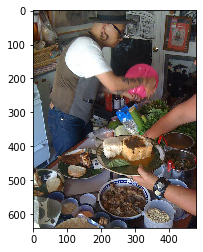

In [23]:
plt.imshow(images[0])

**Now let import and use the additional images**

In [0]:
with open('/content/drive/My Drive/Final_Project/Dataset/More/additional_images_info.json') as json_file:
     images_info_additional = json.load(json_file)

In [0]:
names_additional = []
ids_names_additional = []
heights_additional = []
widths_additional = []

for i in range(len(images_info_additional)):
    names_additional.append(images_info_additional[i]['file_name'])
    heights_additional.append(images_info_additional[i]['height'])
    widths_additional.append(images_info_additional[i]['width'])
    ids_names_additional.append(images_info_additional[i]['id'])

In [0]:
min_height_additional = min(heights_additional)
min_width_additional = min(widths_additional)

In [0]:
with open('/content/drive/My Drive/Final_Project/Dataset/More/additional_labels.json') as json_file:
     categories_info_additional = json.load(json_file)

In [0]:
category_ids_additional = []
image_category_ids_additional = []
bboxes = []

for i in range(len(categories_info_additional)):
    category_ids_additional.append(categories_info_additional[i]['category_id'])
    image_category_ids_additional.append(categories_info_additional[i]['image_id'])
    bboxes.append(categories_info_additional[i]['bbox'])

**Also we can use the bounding boxes to extract exclusive objects**

In [0]:
images_exclusive = []
label_extracted = []

for u in range(len(category_ids_additional)):

    if category_ids_additional[u] not in label_full_exc:

       box_ext = bboxes[u]
       index = [j for j,x in enumerate(ids_of_images_additional) if x == image_category_ids_additional[u]]

       for v in index:

          image_temp = images_additional[v]

          if len(image_temp) == 3:
              image_ext = image_temp[int(box_ext[1]):int(box_ext[1]+box_ext[3]),int(box_ext[0]):int(box_ext[0]+box_ext[2]),:]
          else:
              image_ext = image_temp[int(box_ext[1]):int(box_ext[1]+box_ext[3]),int(box_ext[0]):int(box_ext[0]+box_ext[2])]

          if np.shape(image_ext)[0] > 250 and np.shape(image_ext)[1] > 250:

                images_exclusive.append(image_ext)
                label_extracted.append(int(category_ids_additional[u]))


In [0]:
np.unique(label_extracted)

In [0]:
47 in label_extracted

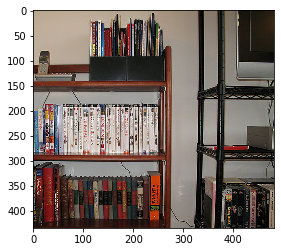

In [0]:
plt.imshow(images_exclusive[15])

**import the Zip file of additional images and according to each additional image id create the additional label file that contain additional category id of each additional image**

In [0]:
archive = zipfile.ZipFile('/content/drive/My Drive/Final_Project/Dataset/More/MoreImages.zip', 'r')
infolist = archive.infolist()

In [0]:
images_additional = []
label_additional = []
ids_of_images_additional = []

for i in infolist:

      label_temp = []
      infile = archive.open(i)
      nam = infile.name

      if '.jpg' in nam:

        name = nam[11:]
        index = names_additional.index(name)
        ind = ids_names_additional[index]
        index_id = [j for j,x in enumerate(image_category_ids_additional) if x == ind]

        for t in index_id:          
            label_temp.append(category_ids_additional[t]-1)

 
        if len(label_temp) != 0:
          
            ids_of_images_additional.append(ind)
            label_additional.append(label_temp)    
            img = Image.open(infile)
            img_arr = np.asarray(img)
            images_additional.append(img_arr)

for u in range(len(label_additional)):
        label_additional[u] = list(np.unique(label_additional[u]))   

In [0]:
len(ids_of_images_additional)

In [0]:
len(images_additional)

In [0]:
for i in range(len(label_additional)):
    for j in range(len(label_additional[i])):
        label_additional[i][j] = dic[label_additional[i][j]]

**convert the each element of label to one hot vectors that have multiple one**

In [34]:
mlb = MultiLabelBinarizer(classes= np.arange(0, 80))
mlb.fit(label_additional)
label_additional1 = mlb.transform(label_additional)
label_additional1[10]

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
label_additional[10]

[2, 3]

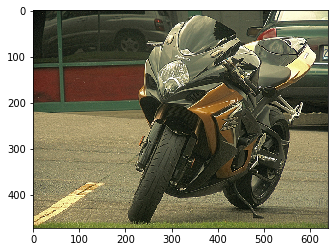

In [36]:
plt.imshow(images_additional[10])

**It's time to combine images and additional images**

In [0]:
images_full = images + images_additional
label_full1 = np.concatenate((label1, label_additional1), 0)
label_full = label + label_additional
ids_of_images_full = ids_of_images + ids_of_images_additional

In [0]:
len(images_full)

In [0]:
len(ids_of_images_full)

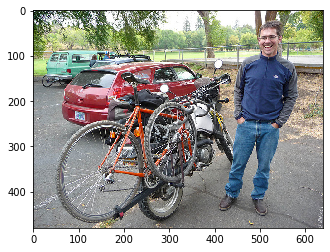

In [40]:
plt.imshow(images_full[100])

In [41]:
label_full[100]

[0, 1, 2, 3, 7]

In [42]:
label_full1[100]

array([1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**Let see the number of occurrence of each label in datasets**

In [0]:
counts = np.zeros([80])
id_labs = np.arange(0,80)

for r in label_full:
    for i in range(len(id_labs)):
        if id_labs[i] in r:
            counts[i] += 1
       

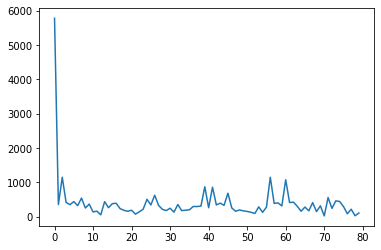

In [44]:
plt.plot(counts)

In [45]:
max_occ = max(counts)
max_occ

5778.0

In [46]:
counts

array([5778.,  354., 1149.,  416.,  352.,  440.,  323.,  543.,  254.,
        368.,  141.,  162.,   56.,  439.,  264.,  381.,  392.,  238.,
        187.,  159.,  190.,   75.,  145.,  220.,  508.,  343.,  626.,
        331.,  215.,  180.,  248.,  133.,  356.,  179.,  191.,  201.,
        299.,  297.,  310.,  872.,  261.,  858.,  344.,  396.,  332.,
        685.,  257.,  159.,  198.,  171.,  155.,  129.,   96.,  288.,
        128.,  279., 1149.,  389.,  403.,  316., 1077.,  413.,  425.,
        306.,  161.,  282.,  172.,  410.,  150.,  317.,   24.,  559.,
        244.,  463.,  444.,  296.,   87.,  219.,   28.,  108.])

**We see that the data is imbalance so to remedy this i use focal loss to train the network**

In [0]:
list(dic.keys())[list(dic.values()).index(79)]

89

In [49]:
len(model_eff.layers)

230

**Let define the Network and see the summary of it**

In [47]:
inputs = Input((100, 100, 3))
model_eff = EfficientNetB0(include_top=False, weights='imagenet', input_shape= (100,100,3))
for layer in model_eff.layers[:225]:
    layer.trainable = False
model_eff_out = model_eff(inputs)  
model_eff_out_flatten = Flatten()(model_eff_out)
drop1 = Dropout(0.25)(model_eff_out_flatten)
dense1 = Dense(128, activation= 'relu')(drop1)
drop2 = Dropout(0.25)(dense1)
dense2 = Dense(80, activation = 'sigmoid')(drop2)

model = Model(input = [inputs],
              output = [dense2])
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
16809984/16804768 [==============================] - 0s 0us/step

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20480)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2621568   
_________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  del sys.path[0]


**For better understanding let see the graphical view of the model**

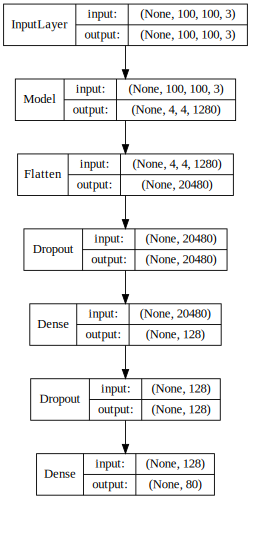

In [50]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi= 65).create(prog='dot', format='svg'))

**Split Data to train and validation set with 95% for train and 5% for validation**

In [0]:
train_images, test_images, train_labels, test_labels,ids_of_images_train, ids_of_images_test = train_test_split(images_full, label_full1, ids_of_images_full, test_size= 0.05035704349438932, random_state= 42)

In [0]:
len(ids_of_images_train)

In [0]:
len(test_images)

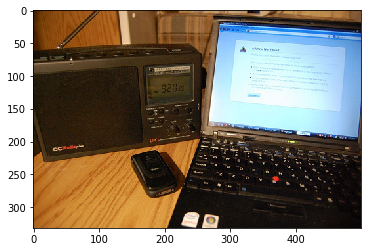

In [54]:
plt.imshow(test_images[0])

In [55]:
test_labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
sgd = SGD(0.0001, 0.9)


def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha_t*((1-p_t)^gamma)*log(p_t)
        
        p_t = y_pred, if y_true = 1
        p_t = 1-y_pred, otherwise
        
        alpha_t = alpha, if y_true=1
        alpha_t = 1-alpha, otherwise
        
        cross_entropy = -log(p_t)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true)*alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1-p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss    

model.compile(sgd, binary_focal_loss())

**Because the size of images are not same and I resize input images in the Network so for training the model we need define the generator**

In [0]:
num_epoch = 20
batch_size_train = 128

In [0]:
"""
The Generator for using Mini_Batch Algorithm in Training Data
"""

# =================== define the Generator ============================

class Generator_Train(Sequence):

    def __init__(self, images, labels, datagen, batch_size):

        self.batch_size = batch_size
        self.max = self.__len__()
        self.n = 0
        self.images = images
        self.labels = labels
        self.datagen = datagen

    def __len__(self):

        number_batches_epoch = int(10240/self.batch_size)
        return number_batches_epoch

    def __getitem__(self, idx):

    
        indexes = range(idx * self.batch_size, (idx + 1) * self.batch_size)
        inputs = []
        outputs = []

        for i in indexes:
            image_temp = self.images[i]
            if len(np.shape(image_temp)) == 2:
                image_temp = np.expand_dims(image_temp, axis= -1)
                image_temp = np.concatenate((image_temp, image_temp, image_temp), axis= 2)

            image_temp = cv2.resize(image_temp, (100,100))
            image_temp = np.expand_dims(image_temp, axis= 0)
            self.datagen.fit(image_temp)
            image_gen = self.datagen.flow(image_temp, batch_size= 4)
            img = next(image_gen)[0]
            img = np.expand_dims(img, 0)
            image_temp = image_temp/255
            img = np.concatenate((img, image_temp), 0)
            for t in range(1, 3):
                  out_pre = next(image_gen)[0]  
                  out_pre = np.expand_dims(out_pre, 0)
                  img = np.concatenate((img, out_pre), 0)

            label_temp = np.array(self.labels[i])
            lab = np.reshape(label_temp, (1,80))
            
            for t in range(1, 4):
                    label_temp = np.reshape(label_temp, (1,80)) 
                    lab = np.concatenate((lab, label_temp), 0)

            inputs.append(img)
            outputs.append(lab)


        inputs = np.concatenate(inputs, 0)
        outputs = np.concatenate(outputs, 0)

        p = [x for x in range(len(inputs))]
        random.shuffle(p) 

        inputs = [inputs[i] for i in p]
        outputs = [outputs[i] for i in p]

        return np.asarray(inputs),  np.asarray(outputs)

    def __next__(self):

        if self.n > self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1

        return result

In [0]:
datagen = ImageDataGenerator(
          rescale=1/255,
          rotation_range=20,
          width_shift_range=0.1,
          height_shift_range=0.1,
          horizontal_flip=True,
          vertical_flip=True)

In [0]:
gen_train = Generator_Train(train_images, train_labels, datagen, batch_size_train)

In [0]:
a,b = next(gen_train)

In [62]:
np.shape(a)

(512, 100, 100, 3)

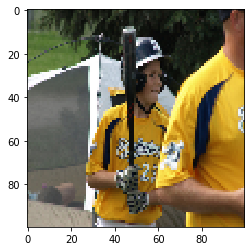

In [63]:
plt.imshow(np.asarray(a[29]*255, 'uint'))

**For the same reason of training the model we need generator to feed validation data to model**





In [0]:
"""
The Generator for using Mini_Batch Algorithm in Test Data
"""
# =================== define the Generator ============================

class Generator_Validation(Sequence):

    def __init__(self, images, labels, batch_size):

        self.batch_size = batch_size
        self.max = self.__len__()
        self.n = 0
        self.images = images
        self.labels = labels

    def __len__(self):

        number_batches_epoch = int(543/self.batch_size)
        return number_batches_epoch

    def __getitem__(self, idx):

    
        indexes = range(idx * self.batch_size, (idx + 1) * self.batch_size)
        inputs = []
        outputs = []

        for i in indexes:
            image_temp = self.images[i]

            if len(np.shape(image_temp)) == 2:
                image_temp = np.expand_dims(image_temp, axis= -1)
                image_temp = np.concatenate((image_temp, image_temp, image_temp), axis= 2)

     
            image_temp = image_temp
            image_temp = cv2.resize(image_temp, (100, 100))
            image_temp = image_temp/255
            image_temp = np.expand_dims(image_temp, axis= 0)
    

            label_temp = np.array(self.labels[i])
            labels = np.reshape(label_temp, (1,80))
          


            inputs.append(image_temp)
            outputs.append(labels)

        inputs = np.concatenate(inputs, 0)
        outputs = np.concatenate(outputs, 0)

        return np.asarray(inputs),  np.asarray(outputs)

    def __next__(self):

        if self.n > self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1

        return result

In [0]:
gen_validation = Generator_Validation(test_images, test_labels, 3)

In [0]:
a, b = next(gen_validation)

In [0]:
a[0]

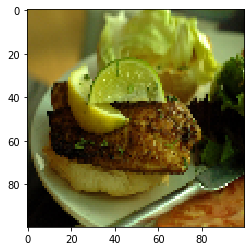

In [68]:
plt.imshow(a[2])

**defne the class to save trained model after each epoch with accuracy and val_accuracy corresponding to that epoch**

In [0]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, accuracy, logs={}):
            
            # save the trained model after each epoch
            self.model.save("/content/drive/My Drive/Final_Project/Trained Model/model {}, val-loss = {:4.3f}, loss = {:4.3f}.hd5".format(epoch+1, accuracy['val_loss'], accuracy['loss']))

Saver = CustomSaver()            

In [72]:
model.fit_generator(gen_train, epochs = num_epoch, workers= 1, validation_data= gen_validation, 
                    use_multiprocessing= True, shuffle= True, callbacks= [Saver])

Epoch 1/20
80/80 [==============================] - 107s 1s/step - loss: 1.0051 - val_loss: 0.9226
Epoch 2/20
80/80 [==============================] - 98s 1s/step - loss: 0.9958 - val_loss: 0.9189
Epoch 3/20
80/80 [==============================] - 104s 1s/step - loss: 0.9895 - val_loss: 0.9104
Epoch 4/20
80/80 [==============================] - 101s 1s/step - loss: 0.9833 - val_loss: 0.9045
Epoch 5/20
80/80 [==============================] - 102s 1s/step - loss: 0.9777 - val_loss: 0.9047
Epoch 6/20
80/80 [==============================] - 100s 1s/step - loss: 0.9725 - val_loss: 0.8964
Epoch 7/20
80/80 [==============================] - 100s 1s/step - loss: 0.9663 - val_loss: 0.8988
Epoch 8/20
80/80 [==============================] - 99s 1s/step - loss: 0.9617 - val_loss: 0.8910
Epoch 9/20
80/80 [==============================] - 97s 1s/step - loss: 0.9517 - val_loss: 0.8909
Epoch 10/20
80/80 [==============================] - 94s 1s/step - loss: 0.9488 - val_loss: 0.8852
Epoch 11/20
8

In [43]:
model = load_model('/content/drive/My Drive/Final_Project/Trained Model/model 19, val-loss = 0.869, loss = 0.913.hd5',
                   custom_objects = {'focal_loss': binary_focal_loss() })



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





**Let Make some prediction with model**

In [0]:
image_temp = cv2.resize(test_images[30], (100, 100))
image_temp = image_temp/255
image_temp = np.expand_dims(image_temp, axis= 0)
pred = model.predict(image_temp)  

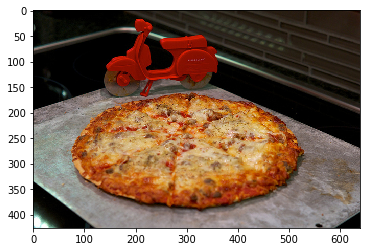

In [44]:
plt.imshow(test_images[30])

In [164]:
ind = [j for j,x in enumerate(test_labels[10]) if x==1]
ind

[0, 18, 24]

In [46]:
np.argmax(pred)

53

In [0]:
list(dic.keys())[list(dic.values()).index(53)] +1 

**After Training the network very well , it's time to extract and save features of images**

In [49]:
model_to_extract = Model(model.input,
                         model.layers[2].output)
model_to_extract.trainable = False
model_to_extract_features = Sequential()
model_to_extract_features.add(model_to_extract)
model_to_extract_features.add(Reshape((4, 4, 1280)))
model_to_extract_features.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 20480)             4049564   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1280)        0         
Total params: 4,049,564
Trainable params: 0
Non-trainable params: 4,049,564
_________________________________________________________________


**Save the extracted features of train images**

In [0]:
q = 1 
# save extracted features of each train image with corresponding image_id
for i in range(len(train_images)):


    img = train_images[i]  
    if len(np.shape(img)) == 2:
        img = np.expand_dims(img, axis= -1)
        img = np.concatenate((img, img, img), axis= 2)

     
    img = cv2.resize(img, (100, 100))
    img = img/255
    img = np.expand_dims(img, axis= 0)
    vector = model_to_extract_features.predict(img)
    id = ids_of_images_train[i]  
    np.savez_compressed('/content/drive/My Drive/Final_Project/features_train/features'+ str(q),
                                              image = train_images[i], feature = vector, id = id)
    print(q)
    q += 1


**save the extracted features of validation images in another file**

In [0]:
q = 1
# save extracted features of each validation image with corresponding image_id
for i in range(len(test_images)):

    img = test_images[i]  
    if len(np.shape(img)) == 2:
        img = np.expand_dims(img, axis= -1)
        img = np.concatenate((img, img, img), axis= 2)

     
    img = cv2.resize(img, (100, 100))
    img = img/255
    img = np.expand_dims(img, axis= 0)
    vector = model_to_extract_features.predict(img)
    id = ids_of_images_test[i]  
    np.savez_compressed('/content/drive/My Drive/Final_Project/a/features'+ str(q),
                                                image = test_images[i] , feature = vector, id = id)
    print(q)
    q += 1

In [0]:
com = np.load('/content/drive/My Drive/Final_Project/features_validation/features1.npz')

In [0]:
im = com['image'] 
fea = com['feature']
di = com['id']

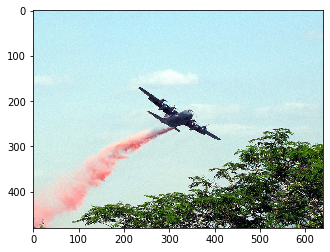

In [158]:
plt.imshow(im)

# RNN Part

**prepare the captions**


---


*   First seperate the captions and image_ids
*   Clean the captions
*   add 'startseq' and 'endseq' to captions and also add          'zero_pad'






In [0]:
with open('/content/drive/My Drive/Colab Notebooks/Deep Course/Final_Project/Dataset/captions.json') as json_file:
     cap = json.load(json_file)

captions = []
caption_ids = []

for i in cap:
  captions.append(i['caption'])
  caption_ids.append(i['image_id'])

**Load the additional Captions**

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/Deep Course/Final_Project/Dataset/More/additional_captions.json') as json_file:
     cap = json.load(json_file)

captions_additional = []
caption_ids_additional = []

for i in cap:
  captions_additional.append(i['caption'])
  caption_ids_additional.append(i['image_id'])

**Combine the captions**

In [0]:
captions_full = captions + captions_additional
caption_ids_full = caption_ids + caption_ids_additional

In [0]:
 caption_ids_full1 = list(np.unique(caption_ids_full))
 len(caption_ids_full1)

15000

In [0]:
caption_ids_full[0]

179765

In [0]:
table = str.maketrans('', '', string.punctuation)
words = []

for i in range(len(captions_full)):

        caption = captions_full[i]        
        caption = caption.split()
        caption = [word.lower() for word in caption]
        caption = [w.translate(table) for w in caption]
        caption = [word for word in caption if len(word)>1]
        caption = [word for word in caption if word.isalpha()]            
        caption.insert(0, 'startseq')
        caption.insert(len(caption), 'endseq')  
        for j in caption:
            words.append(j)
        captions_full[i] = caption
    

**create word to index and index to word with unique words of all captions**

In [0]:
words1 = list(np.unique(words))
len(words1)

11706

In [0]:
words_most_occurence = []
cnt = 1

for i in words1:
    ind = [k for k,x in enumerate(words) if x == i]
    if len(ind) > 9:
        words_most_occurence.append(i)
    print(cnt)
    cnt += 1    

In [0]:
len(words_most_occurence)

2785

In [0]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(words_most_occurence)

word2id = tokenizer.word_index
id2word = tokenizer.index_word

In [0]:
word2id['zero_pad'] = 0
id2word[0] = 'zero_pad'
word2id['rare'] = len(words_most_occurence) + 1 
id2word[len(words_most_occurence) + 1] = 'rare'

In [0]:
id2word[2786]

'rare'

In [0]:
vocab_size = len(words_most_occurence) + 2

In [0]:
vocab_size

2787

**Create appropriate inputs and output to the RNN model**

In [0]:
input_RNN_words = []
target_RNN_words = []
input_RNN_image_ids = []

for i in range(len(captions_full)):

    for j in range(1,len(captions_full[i])):

            input_RNN_words.append(captions_full[i][0:j])
            target_RNN_words.append(captions_full[i][j])
            input_RNN_image_ids.append(caption_ids_full[i])

**Compute Maximum length of captions to use in  zero padding**

In [0]:
length_max = 0
for y in range(len(input_RNN_words)):
    if len(input_RNN_words[y])> length_max:
        length_max = len(input_RNN_words[y])

length_max

46

**Zero padding the captions untill all of them have equal size**

In [0]:
for u in range(len(input_RNN_words)):
    while len(input_RNN_words[u]) < length_max:
          input_RNN_words[u].insert(len(input_RNN_words[u]), 'zero_pad')

**Load the trained word2vec Glov**

In [0]:
embeddings_index = {} # empty dictionary
f = open(os.path.join('/content/drive/My Drive/Final_Project/Dataset/', 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
embedding_dim = 200
embedding_matrix = np.zeros([vocab_size, embedding_dim])

for word, i in word2id[()].items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
       embedding_matrix[i] = embedding_vector

**Using the loaded word2vec to replace words with related vectors**

In [0]:
input_RNN_indexes = []
input_RNN_indexes_temp = []

for i in range(len(input_RNN_words)):
    for j in input_RNN_words[i]:
        if j in word2id:
           input_RNN_indexes_temp.append(word2id[j])
        else:
           input_RNN_indexes_temp.append(word2id['rare'])

        
    input_RNN_indexes.append(input_RNN_indexes_temp)
    input_RNN_indexes_temp = []

In [0]:
np.savez_compressed('/content/drive/My Drive/Colab Notebooks/Deep Course/Final_Project/Model/index_to_words.npz',
id2word = id2word, word2id = word2id, vocab_size= vocab_size, length_max= length_max, input_RNN_indexes = input_RNN_indexes, target_RNN_words = target_RNN_words,
input_RNN_image_ids = input_RNN_image_ids)

In [0]:
com = np.load('/content/drive/My Drive/Final_Project/Model/index_to_words.npz', allow_pickle= True)    
id2word = com['id2word']
word2id = com['word2id']
vocab_size = com['vocab_size']
length_max = com['length_max']
input_RNN_indexes = com['input_RNN_indexes']
target_RNN_words = com['target_RNN_words']
input_RNN_image_ids = com['input_RNN_image_ids']

In [93]:
input_RNN_indexes[1]

array([2273,  226,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

**Define the Generator to train the RNN Network that gives the image_features with corresponding input_vectors and output vector**

In [0]:
num_epoch = 20
batch_size = 4

In [0]:
"""
The Generator for using Mini_Batch Algorithm in Input Data for RNN Network
"""

# =================== define the Generator ============================

class Generator_RNN_Train(Sequence):

    def __init__(self, path_to_features, input_RNN, target_RNN,  input_RNN_ids, vocab_size, word2id, batch_size):

        self.batch_size = batch_size
        self.path_to_features = path_to_features
        lists = self.path_to_features + '/*.npz'
        self.lists = glob(lists) 
        self.input_RNN = input_RNN
        self.target_RNN = target_RNN
        self.input_RNN_ids = input_RNN_ids
        self.vocab_size = vocab_size
        self.word2id = word2id
        self.max = self.__len__()
        self.n = 0

    def __len__(self):

        number_batches_epoch = int(len(self.lists)/self.batch_size)
        return number_batches_epoch

    def __getitem__(self, idx):

        indexes = range(idx * self.batch_size, (idx + 1) * self.batch_size)          
        features = []
        inputs = []
        targets = []

        for i in indexes:
            com = np.load(self.lists[i])
            feature_temp = com['feature']
            feature_temp = np.reshape(feature_temp, [4, 4, 1280])
            id_temp = com['id']
            id_images = [k for k,x in enumerate(self.input_RNN_ids) if x == id_temp]
            for l in id_images:
                features.append(feature_temp)
                inputs.append(self.input_RNN[l])

                if self.target_RNN[l] in self.word2id[()]:
                   targets.append(to_categorical(self.word2id[()][self.target_RNN[l]], self.vocab_size, int))
                else:
                   targets.append(to_categorical(self.word2id[()]['rare'], self.vocab_size, int))


        return [np.asarray(features), np.asarray(inputs)], np.asarray(targets)
   

    def __next__(self):

        if self.n > self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1

        return result

In [0]:
gen_rnn_train = Generator_RNN_Train('/content/drive/My Drive/Final_Project/features_train', input_RNN_indexes, target_RNN_words, input_RNN_image_ids, vocab_size, word2id, 4)
featuresinputs, targets = next(gen_rnn_train)

In [104]:
np.shape(featuresinputs[0][2])

(4, 4, 1280)

In [60]:
list(targets[12]).index(1)

268

**Like for Training the network, defining generator for validating the network**

In [0]:
"""
The Generator for using Mini_Batch Algorithm in Input Data for RNN Network
"""

# =================== define the Generator ============================

class Generator_RNN_Validation(Sequence):

    def __init__(self, path_to_features, input_RNN, target_RNN,  input_RNN_ids, vocab_size, word2id, batch_size):

        self.batch_size = batch_size
        self.path_to_features = path_to_features
        lists = self.path_to_features + '/*.npz'
        self.lists = glob(lists) 
        self.input_RNN = input_RNN
        self.target_RNN = target_RNN
        self.input_RNN_ids = input_RNN_ids
        self.vocab_size = vocab_size
        self.word2id = word2id
        self.max = self.__len__()
        self.n = 0

    def __len__(self):

        number_batches_epoch = int(len(self.lists)/self.batch_size)
        return number_batches_epoch

    def __getitem__(self, idx):

        indexes = range(idx * self.batch_size, (idx + 1) * self.batch_size)
        features = []
        inputs = []
        targets = []

        for i in indexes:

            com = np.load(self.lists[i])
            feature_temp = com['feature']
            feature_temp = np.reshape(feature_temp, [4, 4, 1280])
            id_temp = com['id']
            id_images = [k for k,x in enumerate(self.input_RNN_ids) if x == id_temp]
            for l in id_images:
                features.append(feature_temp)
                inputs.append(self.input_RNN[l])

                if self.target_RNN[l] in self.word2id[()]:
                   targets.append(to_categorical(self.word2id[()][self.target_RNN[l]], self.vocab_size, int))
                else:
                   targets.append(to_categorical(self.word2id[()]['rare'], self.vocab_size, int))
   
        return [np.asarray(features), np.asarray(inputs)], np.asarray(targets)



    def __next__(self):

        if self.n > self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1

        return result

In [0]:
gen_rnn_validation = Generator_RNN_Validation('/content/drive/My Drive/Final_Project/a', input_RNN_indexes, target_RNN_words, input_RNN_image_ids, vocab_size, word2id, 4)
featuresinputs, targets = next(gen_rnn_validation)

In [100]:
np.shape(featuresinputs[0][0])

(4, 4, 1280)

In [65]:
list(targets[2]).index(1)

879

In [66]:
vocab_size

array(2787)

In [0]:
length_max =46

In [0]:
length_max

46

In [0]:
vocab_size= 2787

**Let Define the RNN_Attention Based Part of Image Captioning Network and see it's summary**

In [72]:
latent_dim = 200
embedding_dim = 200

encoder_inputs = Input(shape= (4,4,1280))
encoder_inputs_reshaped = Reshape((4*4, 1280))(encoder_inputs)
encoder_outputs = Dense(latent_dim, activation= 'relu')(encoder_inputs_reshaped)
encoder_outputs = Reshape((16, latent_dim))(encoder_outputs)

averaged_image_features = Lambda(lambda x: K.mean(x, axis=1))
averaged_image_features = averaged_image_features(encoder_inputs_reshaped)

initial_state_h = Dense(latent_dim)(averaged_image_features)
initial_state_c = Dense(latent_dim)(averaged_image_features)
encoder_states = [initial_state_h, initial_state_c]

decoder_inputs = Input(shape= (length_max, ))
decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_state= True, return_sequences= True, dropout= 0.3, name= 'decoder_LSTM')
decoder_outputs, decoder_state_h,  decoder_state_c = decoder_lstm(decoder_embedding, initial_state = encoder_states )

attention = dot([decoder_outputs,encoder_outputs], axes= [2,2])
attention_output = Activation('softmax')(attention)
context = dot([attention_output, encoder_outputs], axes= [2,1])
context_drop = Dropout(0.3)(context)
decoder_combined_context = concatenate([context_drop, decoder_outputs])

output_ave =  Lambda(lambda x: K.mean(x, axis=1))
output_  = output_ave(decoder_combined_context)

output_drop = Dropout(0.3)(output_)
decoder_dense_output = Dense(vocab_size, activation= 'softmax')
output = decoder_dense_output(output_drop)

model_attention = Model(inputs= [encoder_inputs,  decoder_inputs], outputs= output)
model_attention.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 4, 4, 1280)   0                                            
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 16, 1280)     0           input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 46)           0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 1280)         0           reshape_6[0][0]                  
____________________________________________________________________________________________

**For beter Understanding let's see the network's graphical view**

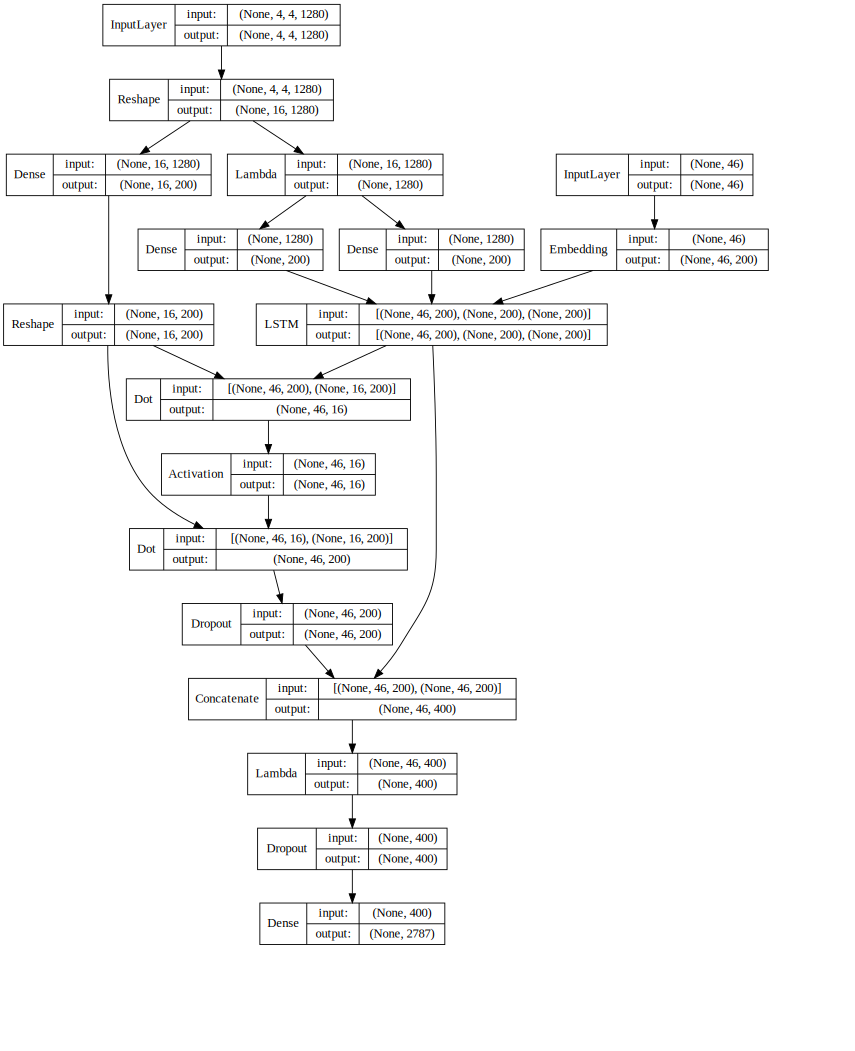

In [73]:
SVG(model_to_dot(model_attention, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi= 65).create(prog='dot', format='svg'))

In [74]:
model_attention.layers[4]

In [0]:
model_attention.layers[4].set_weights([embedding_matrix])
model_attention.layers[4].trainable = False

**Define the optimizer and compile the model**

In [0]:
ADAM = Adam(lr = 0.001) 
model_attention.compile(optimizer= ADAM, loss= categorical_crossentropy, metrics= ['accuracy'])

**Let define the class to Save the trained model after each epoch and then start training**

In [0]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, accuracy,logs={}):
            # save the trained model after each epoch
            self.model.save("/content/drive/My Drive/Final_Project/Trained Model RNN/model {}, val-acc = {:4.3f}, acc = {:4.3f}.hd5".format(epoch+1, accuracy['val_acc'], accuracy['acc']))

Saver = CustomSaver()  

In [0]:
model_attention.fit_generator(gen_rnn_train, epochs = num_epoch, workers= 1, validation_data= gen_rnn_validation, 
                              use_multiprocessing= True, shuffle= True, callbacks= [Saver])

**After training the network, load the best model**

In [0]:
model_attention = load_model("/content/drive/My Drive/Final_Project/Trained Model RNN/model 4, val-acc = 0.287, acc = 0.275.hd5", custom_objects= {'focal_loss': binary_focal_loss()})

**Now it's time to producing the captions for images**

In [0]:
def caption_image_attention(features_validation_path, number_of_chosen_feature):

    com = np.load(features_validation_path + '/features' + str(number_of_chosen_feature) + '.npz')
    features = com['feature']
    di = com['id']
    image = com['image']


    # Populate the first character of target caption with the start character
    par_cap = [word2id[()]['startseq']]
    
    stop_condition = False
    full_cap = []
    par_cap_temp = []
    while not stop_condition:
        
        for i in par_cap:
            par_cap_temp.append(i)
            
        while len(par_cap_temp) < length_max:
           par_cap_temp.append(word2id[()]['zero_pad'])
    
        #par_cap_temp = np.expand_dims(par_cap, 0)
        par_cap_temp = np.reshape(par_cap_temp, [1, 46])
        output_tokens = model_attention.predict([features, par_cap_temp])
    
        # Sample a token with maximum probability
        sampled_token_index = np.argmax(output_tokens[0, :])
        sampled_char = id2word[()][sampled_token_index]
        full_cap.append(sampled_char)
    
        # Exit condition: either hit max length
        # or find stop character
        if (sampled_char == 'endseq' or
           len(full_cap) > length_max):
            stop_condition = True
            if 'endseq' in full_cap:
                full_cap.remove('endseq')
            if 'rare' in full_cap:
                full_cap = [x for j,x in enumerate(full_cap) if x!= 'rare'] 
                
        full_cap = ' '.join(word for word in full_cap)    
        par_cap.append(word2id[()][sampled_char])
        par_cap_temp = []

    return full_cap, image

In [0]:
features_validation_path = "/content/drive/My Drive/Colab Notebooks/Deep Course/Final_Project/features_validation"
number_of_chosen_feature = 1